In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import glob

import gc
import time

import wandb
from pytorch_lightning.loggers import WandbLogger

import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint


from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import torchmetrics

import time
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
from IPython.display import Image
from skimage import io

import segmentation_models_pytorch as smp

from pprint import pprint
from sklearn.model_selection import train_test_split
import cv2
from sklearn.preprocessing import StandardScaler, normalize
from IPython.display import display

from PIL import Image

import torchvision
from torchvision import transforms

import os
import cv2
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision

In [2]:
# Transforms
image_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
])

mask_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
])

# Adjust data function
def adjust_data(img, mask):
    img = img / 255.0
    mask = mask / 255.0
    mask[mask > 0.5] = 1.0
    mask[mask <= 0.5] = 0.0
    return img, mask

# Dataset class
class MyDataset(Dataset):
    def __init__(self, df, adjust_data=adjust_data, image_transform=image_transform, mask_transform=mask_transform):
        self.df = df
        self.image_transform = image_transform
        self.mask_transform = mask_transform
        self.adjust_data = adjust_data

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        image_path = self.df.loc[idx, 'img_path']
        mask_path = self.df.loc[idx, 'mask_path']

        # Read image as grayscale and mask
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        # Adjust image and mask
        image, mask = self.adjust_data(image, mask)

        # Apply transforms
        if self.image_transform:
            image = self.image_transform(image).float()

        if self.mask_transform:
            mask = self.mask_transform(mask)

        return image, mask

# Helper function to create DataFrame from image and mask folder paths
def create_df(image_folder, mask_folder):
    image_paths = []
    mask_paths = []

    for image_name in os.listdir(image_folder):
        image_path = os.path.join(image_folder, image_name)
        mask_path = os.path.join(mask_folder, image_name)  # Ensure masks and images have the same names

        if os.path.isfile(image_path) and os.path.isfile(mask_path):
            image_paths.append(image_path)
            mask_paths.append(mask_path)

    return pd.DataFrame({'img_path': image_paths, 'mask_path': mask_paths})

# Prepare DataLoaders function
def prepare_loaders(image_folder_train, mask_folder_train,
                    image_folder_val, mask_folder_val,
                    image_folder_test, mask_folder_test,
                    batch_size=16):
    # Create DataFrames
    train_df = create_df(image_folder_train, mask_folder_train)
    val_df = create_df(image_folder_val, mask_folder_val)
    test_df = create_df(image_folder_test, mask_folder_test)

    # Create dataset instances
    train_ds = MyDataset(df=train_df)
    val_ds = MyDataset(df=val_df)
    test_ds = MyDataset(df=test_df)

    # Create DataLoaders
    train_loader = DataLoader(train_ds, batch_size=batch_size, num_workers=os.cpu_count(), shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=batch_size, num_workers=os.cpu_count(), shuffle=False)
    test_loader = DataLoader(test_ds, batch_size=4, num_workers=os.cpu_count(), shuffle=True)

    print("DataLoader Completed")

    return train_loader, val_loader, test_loader

In [3]:
# Example paths
image_folder_train = '/data2/Rishika/arcade/arcade/stenosis/train/images'
mask_folder_train = '/data2/Rishika/arcade/arcade/stenosis/train/masks'
image_folder_val = '/data2/Rishika/arcade/arcade/stenosis/val/images'
mask_folder_val = '/data2/Rishika/arcade/arcade/stenosis/val/masks'
image_folder_test = '/data2/Rishika/arcade/arcade/stenosis/test/images'
mask_folder_test = '/data2/Rishika/arcade/arcade/stenosis/test/masks'

train_loader, val_loader, test_loader = prepare_loaders(
    image_folder_train, mask_folder_train,
    image_folder_val, mask_folder_val,
    image_folder_test, mask_folder_test,
    batch_size=16
)

import torch
import torch.nn as nn
import pytorch_lightning as pl
import segmentation_models_pytorch as smp
from catalyst.metrics import iou

# Function to compute accuracy
def accuracy(preds, targets):
    preds = (preds > 0.5).float()  # Convert logits to binary predictions
    correct = (preds == targets).float().sum()
    acc = correct / targets.numel()
    return acc

# Function to compute precision
def precision(preds, targets):
    preds = (preds > 0.5).float()
    true_positive = (preds * targets).sum()
    predicted_positive = preds.sum()
    return true_positive / (predicted_positive + 1e-7)

# Function to compute recall
def recall(preds, targets):
    preds = (preds > 0.5).float()
    true_positive = (preds * targets).sum()
    actual_positive = targets.sum()
    return true_positive / (actual_positive + 1e-7)

# Function to compute F1 score
def f1_score(preds, targets):
    prec = precision(preds, targets)
    rec = recall(preds, targets)
    return 2 * (prec * rec) / (prec + rec + 1e-7)

class SegmentationModel(pl.LightningModule):
    def __init__(self, lr=0.0001):
        super(SegmentationModel, self).__init__()
        # Define the U-Net++ model
        self.model = smp.UnetPlusPlus(
            encoder_name="resnet34",  # Use ResNet-34 as the encoder
            in_channels=1,            # Input channels (grayscale input)
            classes=1                 # Output channels (binary segmentation)
        )
        # Use BCEWithLogitsLoss for binary segmentation
        self.criterion = nn.BCEWithLogitsLoss()
        self.lr = lr

    def forward(self, x):
        return self.model(x)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        return optimizer

    def step(self, batch):
        x, y = batch
        preds = self.forward(x)

        # Compute binary cross-entropy loss
        seg_loss = self.criterion(preds, y)

        # Convert predicted logits to binary values (0 or 1)
        con_pred = torch.sigmoid(preds)

        # Calculate metrics
        acc = accuracy(con_pred, y)              # Accuracy
        dic = f1_score(con_pred, y)              # F1 Score
        io = iou(con_pred, y)                    # IoU
        prec = precision(con_pred, y)            # Precision
        rec = recall(con_pred, y)                # Recall

        loss = seg_loss
        logs = {
            'loss': loss,
            'seg_loss': seg_loss,
            'IOU': io,
            'DICE': dic,
            'Accuracy': acc,
            'Precision': prec,
            'Recall': rec
        }
        return loss, logs

    def training_step(self, batch, batch_idx):
        loss, logs = self.step(batch)
        self.log('train_loss', logs['loss'])
        self.log('train_IOU', logs['IOU'])
        self.log('train_DICE', logs['DICE'])
        self.log('train_accuracy', logs['Accuracy'])
        self.log('train_precision', logs['Precision'])
        self.log('train_recall', logs['Recall'])
        return loss

    def validation_step(self, batch, batch_idx):
        loss, logs = self.step(batch)
        self.log('val_loss', logs['loss'], prog_bar=True)
        self.log('val_IOU', logs['IOU'], prog_bar=True)
        self.log('val_DICE', logs['DICE'], prog_bar=True)
        self.log('val_accuracy', logs['Accuracy'], prog_bar=True)
        self.log('val_precision', logs['Precision'], prog_bar=True)
        self.log('val_recall', logs['Recall'], prog_bar=True)
        return loss

    def test_step(self, batch, batch_idx):
        loss, logs = self.step(batch)
        self.log('test_loss', logs['loss'], prog_bar=True)
        self.log('test_IOU', logs['IOU'], prog_bar=True)
        self.log('test_DICE', logs['DICE'], prog_bar=True)
        self.log('test_accuracy', logs['Accuracy'], prog_bar=True)
        self.log('test_precision', logs['Precision'], prog_bar=True)
        self.log('test_recall', logs['Recall'], prog_bar=True)
        return loss

DataLoader Completed


In [4]:
model= SegmentationModel()

In [7]:
trainer = pl.Trainer(
    devices=[0], 
    accelerator='gpu',
    max_epochs= 100,
    precision=16)
    # callbacks=[checkpoint_callback, early_stop, SWA])

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [8]:
trainer.fit(
    model, 
    train_dataloaders = train_loader, 
    val_dataloaders = val_loader)

RuntimeError: The NVIDIA driver on your system is too old (found version 10020). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver.

In [7]:
# run validation dataset
valid_metrics = trainer.validate(model, dataloaders=val_loader, verbose=True)
pprint(valid_metrics)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]


Validating: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{'val_DICE': 0.4783960861747364,
 'val_IOU': 0.307103572444337,
 'val_accuracy': 0.992552638053894,
 'val_loss': 0.043949587248853624,
 'val_precision': 0.6057503736195978,
 'val_recall': 0.4003399060125111}
--------------------------------------------------------------------------------
[{'val_DICE': 0.4783960861747364,
  'val_IOU': 0.307103572444337,
  'val_accuracy': 0.992552638053894,
  'val_loss': 0.043949587248853624,
  'val_precision': 0.6057503736195978,
  'val_recall': 0.4003399060125111}]


In [8]:
# run test dataset
test_metrics = trainer.test(model, dataloaders=test_loader,verbose=True)
pprint(test_metrics)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_DICE': 0.4933121238234935,
 'test_IOU': 0.32618848912481935,
 'test_accuracy': 0.9915778636932373,
 'test_loss': 0.048559054544347065,
 'test_precision': 0.5843700242195095,
 'test_recall': 0.4420334698159233}
--------------------------------------------------------------------------------
[{'test_DICE': 0.4933121238234935,
  'test_IOU': 0.32618848912481935,
  'test_accuracy': 0.9915778636932373,
  'test_loss': 0.048559054544347065,
  'test_precision': 0.5843700242195095,
  'test_recall': 0.4420334698159233}]


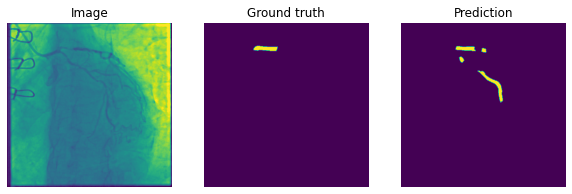

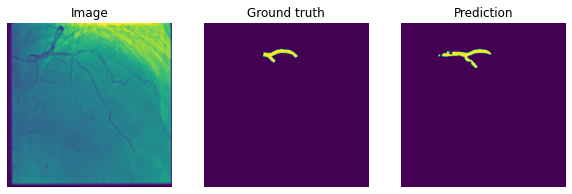

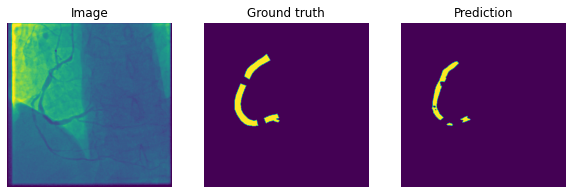

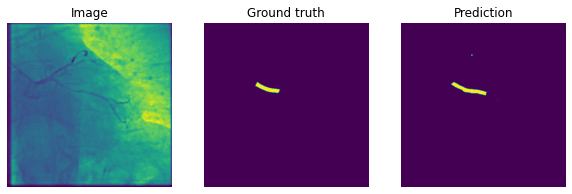

In [21]:
batch = next(iter(test_loader))
with torch.no_grad():
    model.eval()
    logits = model(batch[0])
    # logits = model(batch[0][:4])
pr_masks = (logits.sigmoid() > .5).float()

# for image, gt_mask, pr_mask in zip(batch[0][:4], batch[1][:4], pr_masks):
for image, gt_mask, pr_mask in zip(batch[0], batch[1], pr_masks):
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(image.detach().cpu().numpy().transpose(1, 2, 0))  # convert CHW -> HWC
    plt.title("Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(gt_mask.squeeze().detach().cpu().numpy()) # just squeeze classes dim, because we have only one class
    plt.title("Ground truth")
    plt.axis("off")
    plt.subplot(1, 3, 3)
    plt.imshow(pr_mask.squeeze().numpy()) # just squeeze classes dim, because we have only one class
    plt.title("Prediction")
    plt.axis("off")

    plt.show()